In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

In [3]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [4]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)
# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

# Get table describing ophys experiments *MOST USEFUL TABLE TO LOOK AT
ophys_experiments = cache.get_ophys_experiment_table()  

print('Number of ophys experiments = {}'.format(len(ophys_experiments)))

# get metadata tables
#behavior_sessions = cache.get_behavior_session_table()


#ophys_sessions = cache.get_ophys_session_table()


#ophys_cells = cache.get_ophys_cells_table()

#print number of items in each table for all imaging and behavioral sessions
#print('Number of behavior sessions = {}'.format(len(behavior_sessions)))
#print('Number of ophys sessions = {}'.format(len(ophys_sessions)))

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_data_formatting

import pickle as pickle

Number of ophys experiments = 1936


/opt/conda/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [5]:
# Build desired events/dff/behavior table for a single animal

def get_stacked_change_response(ophys_experiment_id):
    # Load the data for this ophys experiment from the cache
    ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)

    # Get stimulus presentations
    #stimulus_presentations = ophys_experiment.stimulus_presentations.copy()
    
    
    stimulus_presentations = behavior_data_formatting.get_annotated_stimulus_presentations(ophys_experiment, epoch_duration_mins=5)


    # Add a column for whether the previous image was novel
    stimulus_presentations['prev_image_novel'] = stimulus_presentations['is_image_novel'].shift(1)
    
    # Save a subset of the columns in stimulus presentations
    stim_presentations_subset = stimulus_presentations[['trials_id','stimulus_block_name', 'image_index', 'image_name', 'duration', 
                                                        'start_time', 'end_time','start_frame', 'end_frame', 'is_change', 'is_image_novel', 
                                                        'prev_image_novel', 'omitted', 'flashes_since_change', 'is_sham_change', 'active',
                                                        'stimulus_name', 'licks', 'change_trials_id', 'change_time', 'go', 'catch', 
                                                        'auto_rewarded', 'hit', 'miss', 'false_alarm', 'correct_reject', 'response_time',
                                                        'reward_time', 'reward_volume', 'response_latency', 'time_from_last_change', 'licked', 
                                                        'stimulus_count_within_trial', 'previous_image_name', 'previous_response_on_trial',
                                                        'previous_change_on_trial', 'could_change', 'pre_change', 'lick_on_next_flash', 
                                                        'pre_omitted', 'post_omitted', 'reward_rate','engaged', 'engagement_state', 'epoch']]
    
    
    
    

    # Get stimulus aligned responses for all cells in this dataset: dFF
    stim_response_dff = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='dff', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=30)

    # Get stimulus aligned responses for all cells in this dataset: events
    # stim_response_events = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='events', event_type='changes',
    #                                                         time_window=[-1, 0.75], response_window_duration=0.25,
    #                                                         interpolate=True, output_sampling_rate=10)
    
    # Get stimulus aligned responses for all cells in this dataset: filtered events
    stim_response_filtered_events = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='filtered_events', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=10)
    
    # Get stimulus aligned responses for all cells in this dataset: running speed
    stim_response_running_speed = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='running_speed', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=30)
    
    # Get stimulus aligned responses for all cells in this dataset: pupil_diameter
    stim_response_pupil_diameter = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='pupil_diameter', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=30)
    
    
    # Get stimulus aligned responses for all cells in this dataset: lick rate
    stim_response_lick_rate = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='lick_rate', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=30)
    
 



    # Rename the trace columns to be specific to dff
    stim_response_dff.rename(columns={"trace": "dff_trace", "mean_response": "dff_mean_response", 
                                  "baseline_response": "dff_baseline_response"}, inplace=True)



    # Add the events trace columns to the stim_response_dff data frame
    # stim_response_dff['events_trace'] = stim_response_events['trace']
    # stim_response_dff['events_mean_response'] = stim_response_events['mean_response']
    # stim_response_dff['events_baseline_response'] = stim_response_events['baseline_response']
    
    
    
    # Add the filtered events trace columns to the stim_response_dff data frame
    stim_response_dff['filtered_events_trace'] = stim_response_filtered_events['trace']
    stim_response_dff['filtered_events_mean_response'] = stim_response_filtered_events['mean_response']
    stim_response_dff['filtered_events_baseline_response'] = stim_response_filtered_events['baseline_response']
    stim_response_dff['filtered_events_trace_timestamps'] = stim_response_filtered_events['trace_timestamps']
    
    
    # Add the running_speed trace columns to the stim_response_dff data frame
    stim_response_dff['running_speed_trace'] = stim_response_running_speed['trace']
    stim_response_dff['running_speed_mean_response'] = stim_response_running_speed['mean_response']
    stim_response_dff['running_speed_baseline_response'] = stim_response_running_speed['baseline_response']
    
    
    # Add the pupil_diameter trace columns to the stim_response_dff data frame
    stim_response_dff['pupil_diameter_trace'] = stim_response_pupil_diameter['trace']
    stim_response_dff['pupil_diameter_mean_response'] = stim_response_pupil_diameter['mean_response']
    stim_response_dff['pupil_diameter_baseline_response'] = stim_response_pupil_diameter['baseline_response']
    
    
    # Add the lick_rate trace columns to the stim_response_dff data frame
    stim_response_dff['lick_rate_trace'] = stim_response_lick_rate['trace']
    stim_response_dff['lick_rate_mean_response'] = stim_response_lick_rate['mean_response']
    stim_response_dff['lick_rate_baseline_response'] = stim_response_lick_rate['baseline_response']
    
    
    
    
    


    # Merge the stimulus response dataframe with the stimulus table to get information about what stimuli were presented 
    stim_response_stack = stim_response_dff.merge(stim_presentations_subset, on='stimulus_presentations_id')



    stim_response_stack['ophys_experiment_id'] = ophys_experiment_id

    

    return stim_response_stack
    

In [6]:
ophys_experiments = ophys_experiments.sort_values(by=['cre_line', 'mouse_id', 'date_of_acquisition'])
#ophys_experiments[['mouse_id', 'cre_line', 'sex', 'date_of_acquisition', 'session_type', 'session_number', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

In [7]:
# Get only the OPHYS_4 experiments with no prior exposure to the novel image set
subset_ophys_experiments = ophys_experiments[(ophys_experiments.project_code=='VisualBehaviorMultiscope4areasx2d')&
                        (ophys_experiments.session_number==4) &
                        (ophys_experiments.prior_exposures_to_image_set==0)]

# Sort the filtered experiments by genotype, sex, mouse ID
subset_ophys_experiments = subset_ophys_experiments.sort_values(by=['cre_line', 'targeted_structure', 'sex', 'mouse_id'])


#subset_ophys_experiments[['cre_line', 'targeted_structure', 'sex', 'mouse_id', 'session_type', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

# there are 4 Slc17a7 animals, 4 Sst animals, and 4 Vip animals

In [8]:
# Get only the slc17a7 experiments with no prior exposure to the novel image set
slc17a7_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Slc17a7-IRES2-Cre')]

# Get only the Sst experiments
sst_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Sst-IRES-Cre')]

# Get only the Vip experiments
vip_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Vip-IRES-Cre')]


In [9]:
# CHANGE THIS TO ITERATE OVER GENOTYPES
curr_mouse_genotype = vip_ophys_experiments

# CHANGE THIS TO SAVE TO THE CORRECT FOLDER
end_folder = 'vip-cre'

# CHANGE THIS TO ITERATE OVER MICE OF A GIVEN GENOTYPE
#curr_mouse_index = 3

In [10]:
curr_mouse_genotype.groupby(['mouse_id', 'ophys_experiment_id']).count().reset_index().groupby(['mouse_id']).count()[['ophys_experiment_id']]


,ophys_experiment_id
mouse_id,
489065,5
499478,7
550603,8
554115,8


In [11]:
# Get the list of mouse ids for the current genotype
mouse_id_list = curr_mouse_genotype.mouse_id.unique()
mouse_id_list

array(['489065', '499478', '550603', '554115'], dtype=object)

In [12]:
file_path = '/root/capsule/my_results/pickle_stackedcells_imagechange/' + end_folder + '/'
image_path = '/root/capsule/my_results/figures/concatenated_imagechange_cellavg/'


In [13]:
vip_stacked_dict = {}
vip_stacked_df = pd.DataFrame()
for mouse_id in mouse_id_list:
    curr_name = 'stacked_data_df_' + mouse_id + '.pkl'
    stacked_data_df = pd.read_pickle(file_path+curr_name)
    
    stacked_data_df = stacked_data_df.merge(subset_ophys_experiments, left_on='ophys_experiment_id', 
                                      right_index=True, how='left')

    
    
    vip_stacked_dict[mouse_id] = stacked_data_df
    vip_stacked_df = pd.concat([vip_stacked_df, stacked_data_df])
    

In [14]:
# curr_df = vip_stacked_dict[mouse_id_list[0]]
curr_df = vip_stacked_df

In [15]:
curr_df

,stimulus_presentations_id,cell_specimen_id,dff_trace,trace_timestamps,dff_mean_response,dff_baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,...,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
0,49,1120056701,"[0.8186899813913, 0.8186899813913, 0.818689981...","[-1.0, -0.9666666666666667, -0.933333333333333...",0.371921,0.290479,0.0539,30,dff,changes,...,False,Novel 1,0,0,3,2020-02-26 14:38:15.159000+00:00,MESO.1,2021-08-12,972289328,1898
1,49,1120056811,"[1.0093947754133876, 1.0093947754133876, 1.009...","[-1.0, -0.9666666666666667, -0.933333333333333...",0.601964,1.165616,0.0000,30,dff,changes,...,False,Novel 1,0,0,3,2020-02-26 14:38:15.159000+00:00,MESO.1,2021-08-12,972289328,1898
2,49,1120057095,"[-0.013600925963177558, -0.013600925963177558,...","[-1.0, -0.9666666666666667, -0.933333333333333...",-0.030122,0.057898,1.0000,30,dff,changes,...,False,Novel 1,0,0,3,2020-02-26 14:38:15.159000+00:00,MESO.1,2021-08-12,972289328,1898
3,49,1120057181,"[0.9198940495912051, 0.9198940495912051, 0.919...","[-1.0, -0.9666666666666667, -0.933333333333333...",0.409494,0.657524,0.0077,30,dff,changes,...,False,Novel 1,0,0,3,2020-02-26 14:38:15.159000+00:00,MESO.1,2021-08-12,972289328,1898
4,49,1120057412,"[-0.1397878414312291, -0.1397878414312291, -0....","[-1.0, -0.9666666666666667, -0.933333333333333...",-0.105496,0.030003,1.0000,30,dff,changes,...,False,Novel 1,0,0,3,2020-02-26 14:38:15.159000+00:00,MESO.1,2021-08-12,972289328,1898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,4798,1120128668,"[-0.08065060044971183, -0.08056083807444478, -...","[-1.0, -0.9666666666666667, -0.933333333333333...",0.004319,0.004343,0.9893,30,dff,changes,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,653
13928,4798,1120128772,"[-0.035371008068301554, -0.03634242055980429, ...","[-1.0, -0.9666666666666667, -0.933333333333333...",-0.017763,-0.003712,1.0000,30,dff,changes,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,653
13929,4798,1120128849,"[0.08746030736508609, 0.08512830490138863, 0.0...","[-1.0, -0.9666666666666667, -0.933333333333333...",-0.029103,-0.039279,1.0000,30,dff,changes,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,653
13930,4798,1120128991,"[-0.098361690304916, -0.0943315936988365, -0.0...","[-1.0, -0.9666666666666667, -0.933333333333333...",0.017715,0.005155,0.0000,30,dff,changes,...,False,Novel 1,0,0,4,2021-04-22 11:15:14.707000+00:00,MESO.1,2021-08-12,1067796411,653


In [16]:
# # for mouse_id in mouse_id_list:
#     curr_name = 'stacked_data_df_' + mouse_id + '.pkl'
#     curr_df = pd.read_pickle(file_path+curr_name)
    
#     # Sort the filtered experiments by cell_id
#     curr_df = curr_df.sort_values(by=['mouse_id', 'cell_specimen_id', 'stimulus_presentations_id'])
    
#     # Get only the stimulus presentations with image change novel to novel
#     stim_response_stack_nn = curr_df[(curr_df.prev_image_novel==True)&
#                         (curr_df.is_image_novel==True)]

#     #novel to familiar
#     stim_response_stack_nf = curr_df[(curr_df.prev_image_novel==True) &
#                                          (curr_df.is_image_novel==False)]

#     #familiar to familiar
#     stim_response_stack_ff = curr_df[(curr_df.prev_image_novel==False) &
#                                              (curr_df.is_image_novel==False)]

#     #familiar to novel
#     stim_response_stack_fn = curr_df[(curr_df.prev_image_novel==False) &
#                                              (curr_df.is_image_novel==True)]
#     stim_response_stack_list = [stim_response_stack_nn, stim_response_stack_nf, stim_response_stack_ff, stim_response_stack_fn]
#     timestamps = curr_df.trace_timestamps.values[0]

#     #Initialize a data list which will eventually contain n_cells rows and 4 columns (1 for each image change type)
#     data_list = []

#     # Run a loop over each cell:
#     for cell_specimen_id in curr_df.cell_specimen_id.unique():

#         cell_mean_list = []

#         for stim_response_imagechange in stim_response_stack_list:
#             # get the relevant data nn
#             cell_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id)]
#             # get the average dff trace
#             mean_trace = cell_df.dff_trace.mean()
#             cell_mean_list += [mean_trace]
#         data_list.append(list(cell_mean_list))
    
#     data_array = np.array(data_list)

#     data_flat = data_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)


    
    

In [17]:
# Sort the filtered experiments by cell_id
curr_df = curr_df.sort_values(by=['mouse_id', 'cell_specimen_id', 'stimulus_presentations_id'])


In [18]:
curr_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       ...
       'passive', 'experience_level', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'date_of_acquisition', 'equipment_name', 'published_at',
       'isi_experiment_id', 'file_id'],
      dtype='object', length=104)

In [19]:
# # CALCULATE HIT RATE
# single_cell_df = curr_df[curr_df['cell_specimen_id']==1120054836]
# single_cell_df

# single_cell_df.groupby(['image_change_type', 'stimulus_presentations_id']).count().reset_index().groupby(['image_change_type']).count()[['stimulus_presentations_id']]

# single_cell_df.groupby(['image_change_type'])['miss'].sum()
    
# single_cell_df.groupby(['image_change_type'])['hit'].sum()



In [20]:
curr_df.groupby(['mouse_id', 'cell_specimen_id']).count().reset_index().groupby(['mouse_id']).count()[['cell_specimen_id']]


,cell_specimen_id
mouse_id,
489065,78
499478,88
550603,114
554115,81


In [21]:
# Get only the stimulus presentations with image change novel to novel
stim_response_stack_nn = curr_df[(curr_df.prev_image_novel==True)&
                        (curr_df.is_image_novel==True)]

#novel to familiar
stim_response_stack_nf = curr_df[(curr_df.prev_image_novel==True) &
                                         (curr_df.is_image_novel==False)]

#familiar to familiar
stim_response_stack_ff = curr_df[(curr_df.prev_image_novel==False) &
                                         (curr_df.is_image_novel==False)]

#familiar to novel
stim_response_stack_fn = curr_df[(curr_df.prev_image_novel==False) &
                                         (curr_df.is_image_novel==True)]

In [22]:
stim_response_stack_nn.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       ...
       'passive', 'experience_level', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'date_of_acquisition', 'equipment_name', 'published_at',
       'isi_experiment_id', 'file_id'],
      dtype='object', length=104)

In [23]:
stim_response_stack_list = [stim_response_stack_nn, stim_response_stack_nf, stim_response_stack_ff, stim_response_stack_fn]
timestamps = curr_df.trace_timestamps.values[0]

#Initialize a data list which will eventually contain n_cells rows and 4 columns (1 for each image change type)
dff_all_list = []
dff_hit_list = []
dff_miss_list = []

filtevent_all_list = []
filtevent_hit_list = []
filtevent_miss_list = []

# Run a loop over each cell:
for cell_specimen_id in curr_df.cell_specimen_id.unique():

    cell_dff_list = []
    cell_dff_hit_list = []
    cell_dff_miss_list = []
    
    cell_filtevent_list = []
    cell_filtevent_hit_list = []
    cell_filtevent_miss_list = []
    
    for stim_response_imagechange in stim_response_stack_list:
        # get the relevant data for each cell
        cell_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id)]
        cell_hit_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id) & 
                                                (stim_response_imagechange.hit==True)]
        cell_miss_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id) & 
                                                (stim_response_imagechange.miss==True)]
        
        # get the average dff trace (all trials)
        mean_trace = cell_df.dff_trace.mean()
        cell_dff_list += [mean_trace]
        # get the average filtered events trace (all trials)
        mean_filtevent = cell_df.filtered_events_trace.mean()
        cell_filtevent_list += [mean_filtevent]
        
        # get the average dff trace (hit trials)
        mean_hit_trace = cell_hit_df.dff_trace.mean()
        cell_dff_hit_list += [mean_hit_trace]
        # get the average filtered events trace (hit trials)
        mean_filtevent_hit = cell_hit_df.filtered_events_trace.mean()
        cell_filtevent_hit_list += [mean_filtevent_hit]
        
        # get the average dff trace (miss trials)
        mean_miss_trace = cell_miss_df.dff_trace.mean()
        cell_dff_miss_list += [mean_miss_trace]
        # get the average filtered events trace (miss trials)
        mean_filtevent_miss = cell_miss_df.filtered_events_trace.mean()
        cell_filtevent_miss_list += [mean_filtevent_miss]
        
    dff_all_list.append(list(cell_dff_list))
    dff_hit_list.append(list(cell_dff_hit_list))
    dff_miss_list.append(list(cell_dff_miss_list))
    
    filtevent_all_list.append(list(cell_filtevent_list))
    filtevent_hit_list.append(list(cell_filtevent_hit_list))
    filtevent_miss_list.append(list(cell_filtevent_miss_list))
    

In [24]:
# Store all, hit, and miss lists in a list
dff_groups_list = [dff_all_list, dff_hit_list, dff_miss_list]

filtevent_groups_list = [filtevent_all_list, filtevent_hit_list, filtevent_miss_list]

groups_types_list = ['all_trials', 'hit_trials', 'miss_trials']

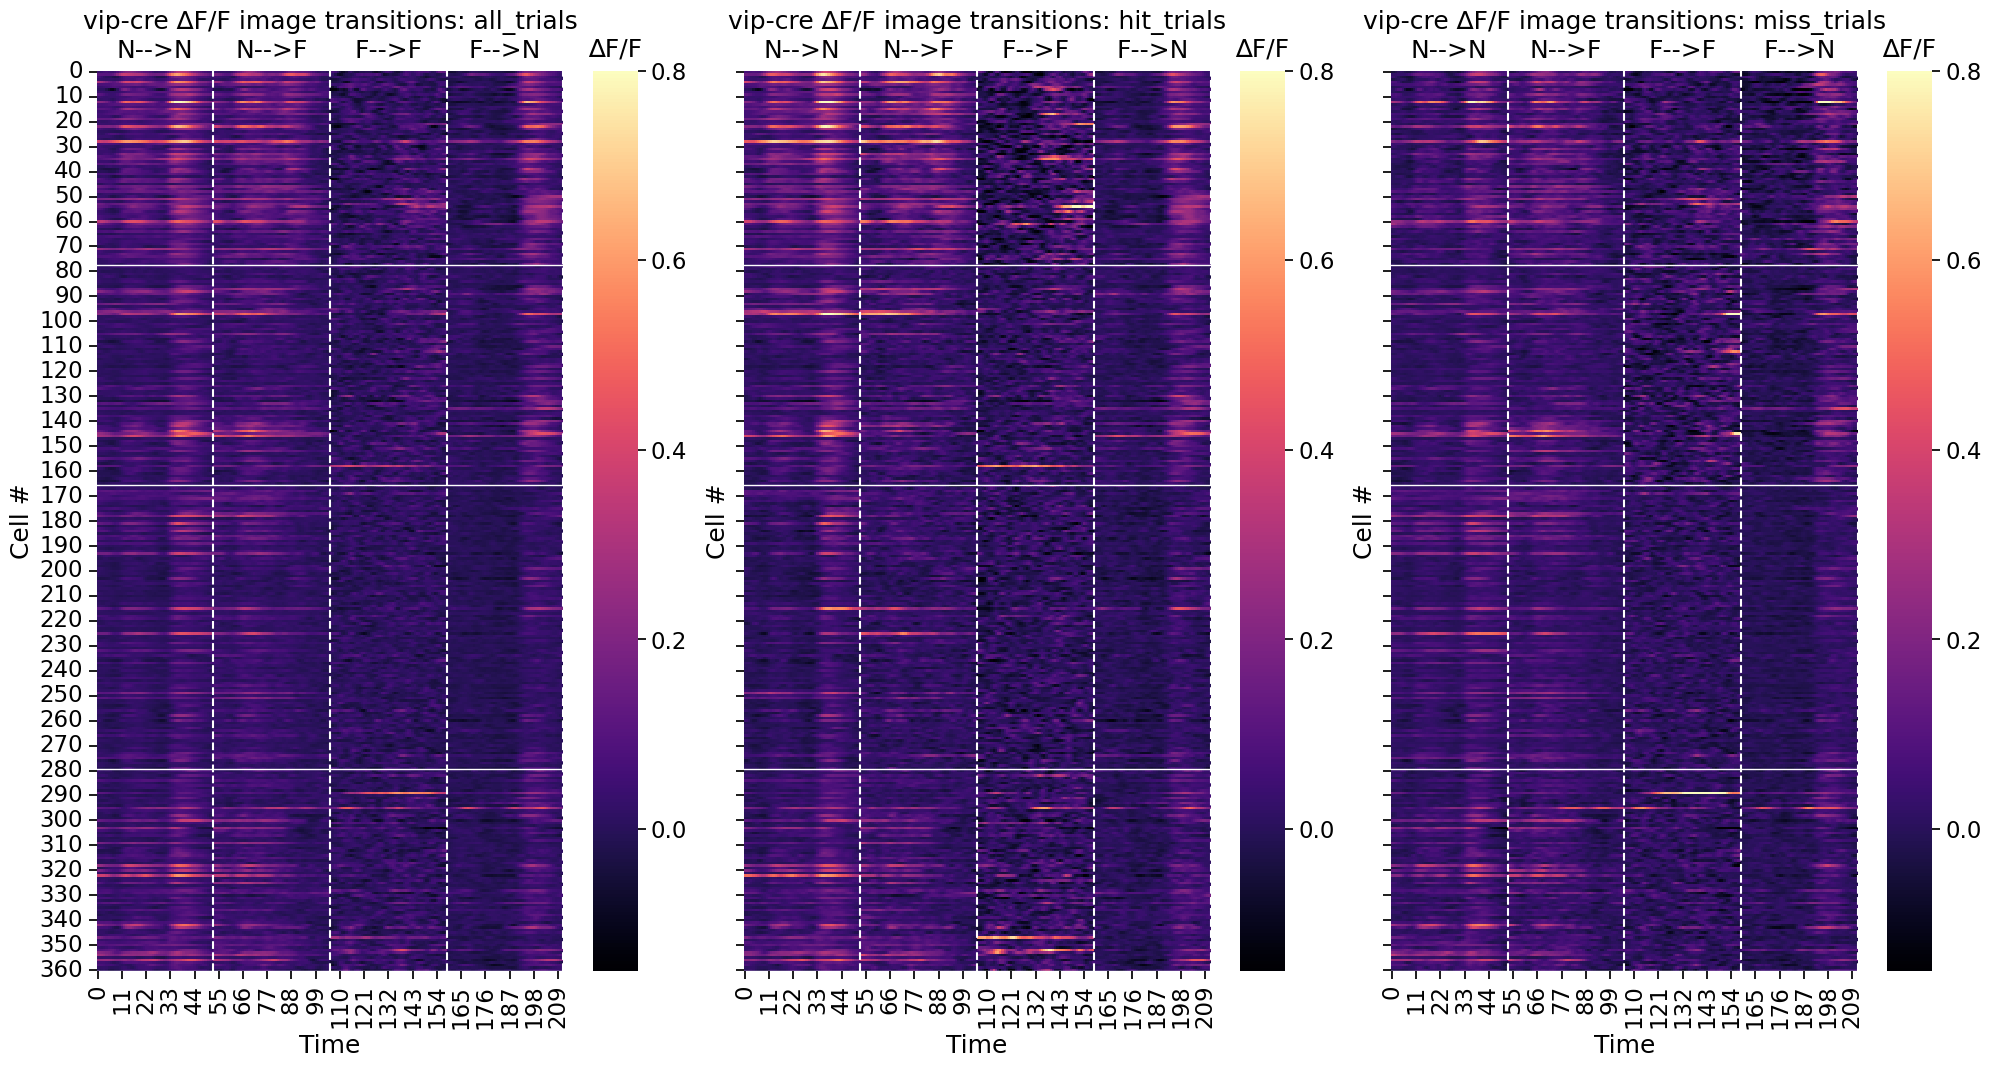

In [25]:
fig, axs = plt.subplots(1,3, sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (20, 10), #have fig-size depend on number of companys/metrics
                        )
fig.tight_layout()

for n, dff_list in enumerate(dff_groups_list):
    dff_array = np.array(dff_list)
    
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)
    
    
    
    name_list = ['N-->N', 'N-->F', 'F-->F', 'F-->N']
    if n==2:
        sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)
    else:
        sp = sns.heatmap(dff_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0][n], vmin=-0.15, vmax=0.8)
    
    # sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('∆F/F', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = dff_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -5, name_list[i], horizontalalignment='center')
        

        temp_df = vip_stacked_dict[mouse_id_list[i]]
        cell_ct = len(temp_df.cell_specimen_id.unique())
        sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        line_offset = line_offset + cell_ct

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} ∆F/F image transitions: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_xlabel('Time');

# Save as SVG
curr_name_svg = end_folder + '_concat_imagechange.svg'

plt.savefig(image_path+'dff_heatmap_'+curr_name_svg, format="svg")

    

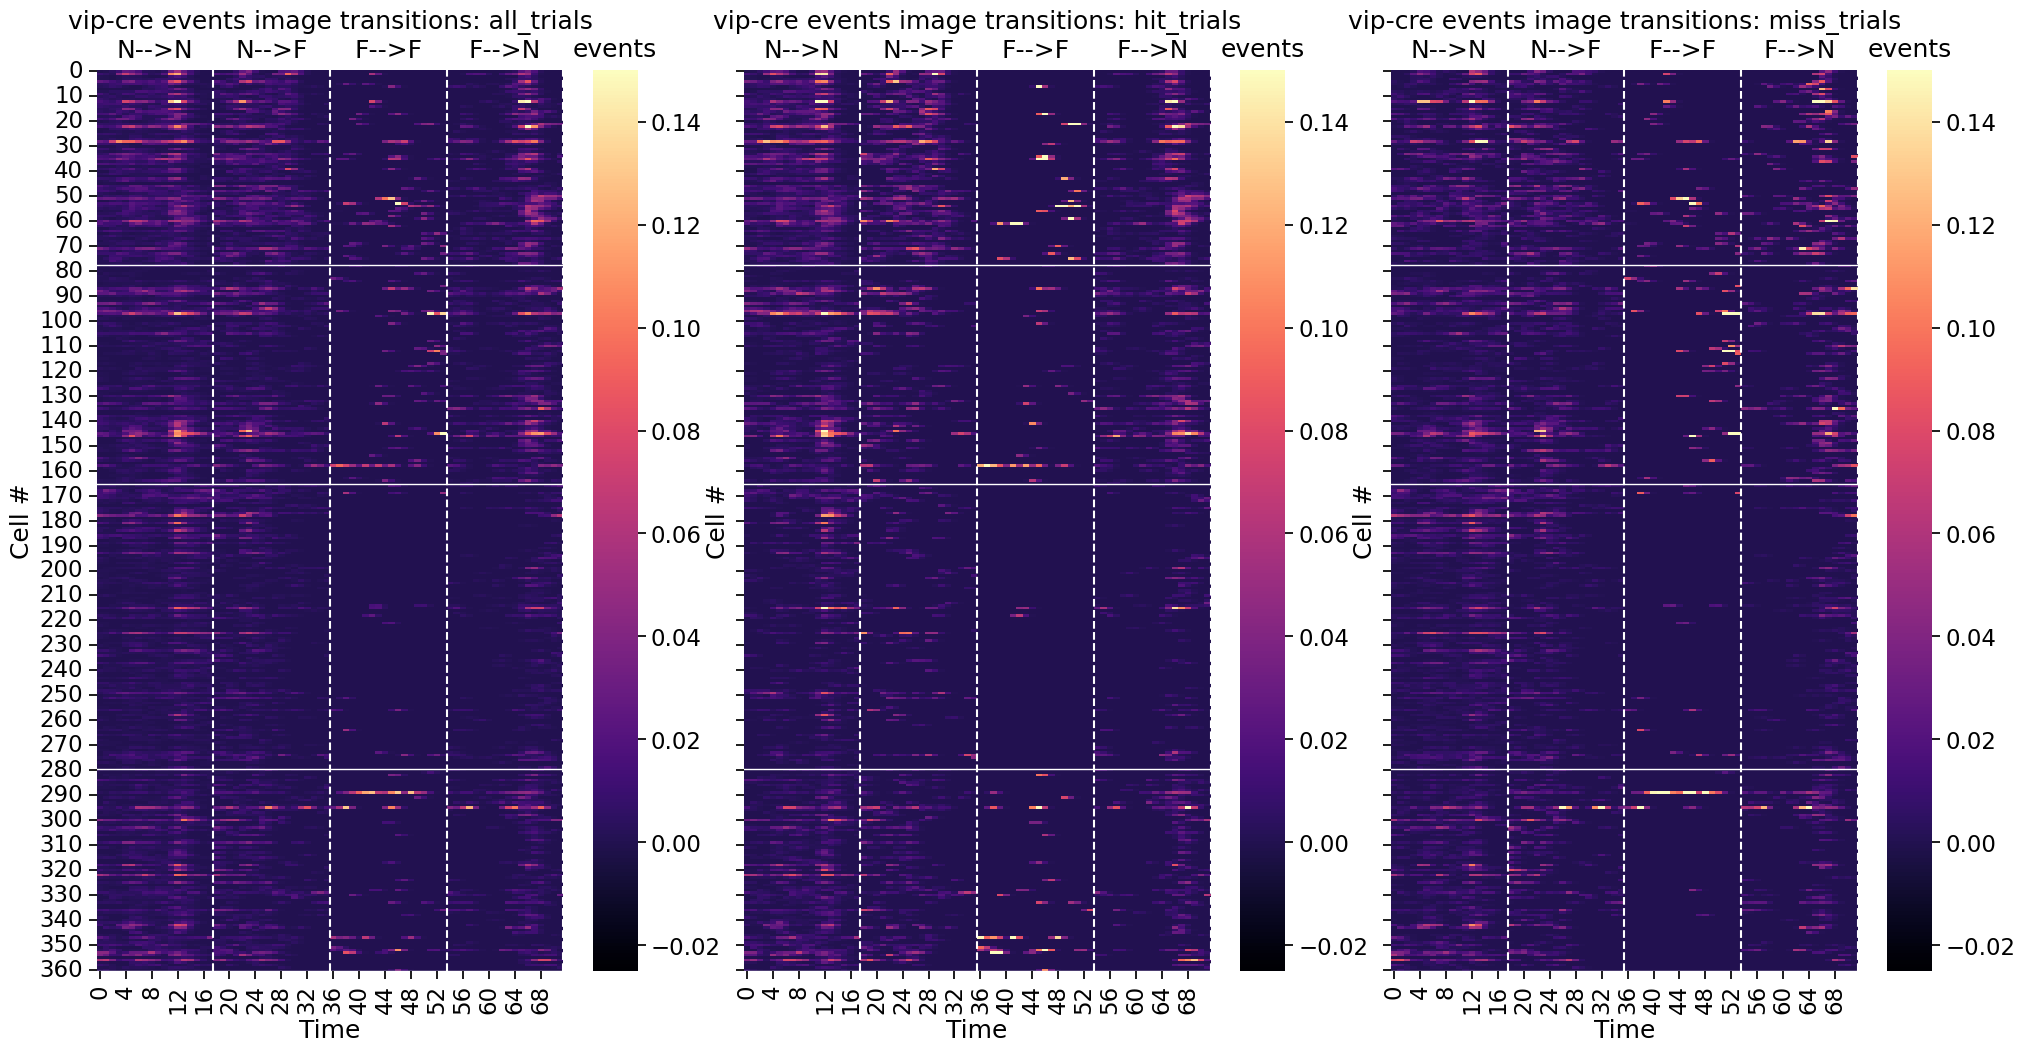

In [26]:
fig, axs = plt.subplots(2,3, sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (20, 10), #have fig-size depend on number of companys/metrics
                        )
fig.tight_layout()

for n, filtevent_list in enumerate(filtevent_groups_list):
    filtevent_array = np.array(filtevent_list)
    
    filtevent_flat = filtevent_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)    
    
    name_list = ['N-->N', 'N-->F', 'F-->F', 'F-->N']
    if n==2:
        sp = sns.heatmap(filtevent_flat,cmap='magma', ax=axs[0][n], 
                         vmin=-0.025, vmax=0.15
                        )
    else:
        sp = sns.heatmap(filtevent_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0][n], 
                         vmin=-0.025, vmax=0.15
                        )
    
    # sp = sns.heatmap(events_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('events', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = filtevent_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -5, name_list[i], horizontalalignment='center')
        

        temp_df = vip_stacked_dict[mouse_id_list[i]]
        cell_ct = len(temp_df.cell_specimen_id.unique())
        sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        line_offset = line_offset + cell_ct

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} events image transitions: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_xlabel('Time');

# Save as SVG

plt.savefig(image_path+'filtevents_heatmap_'+curr_name_svg, format="svg")

    

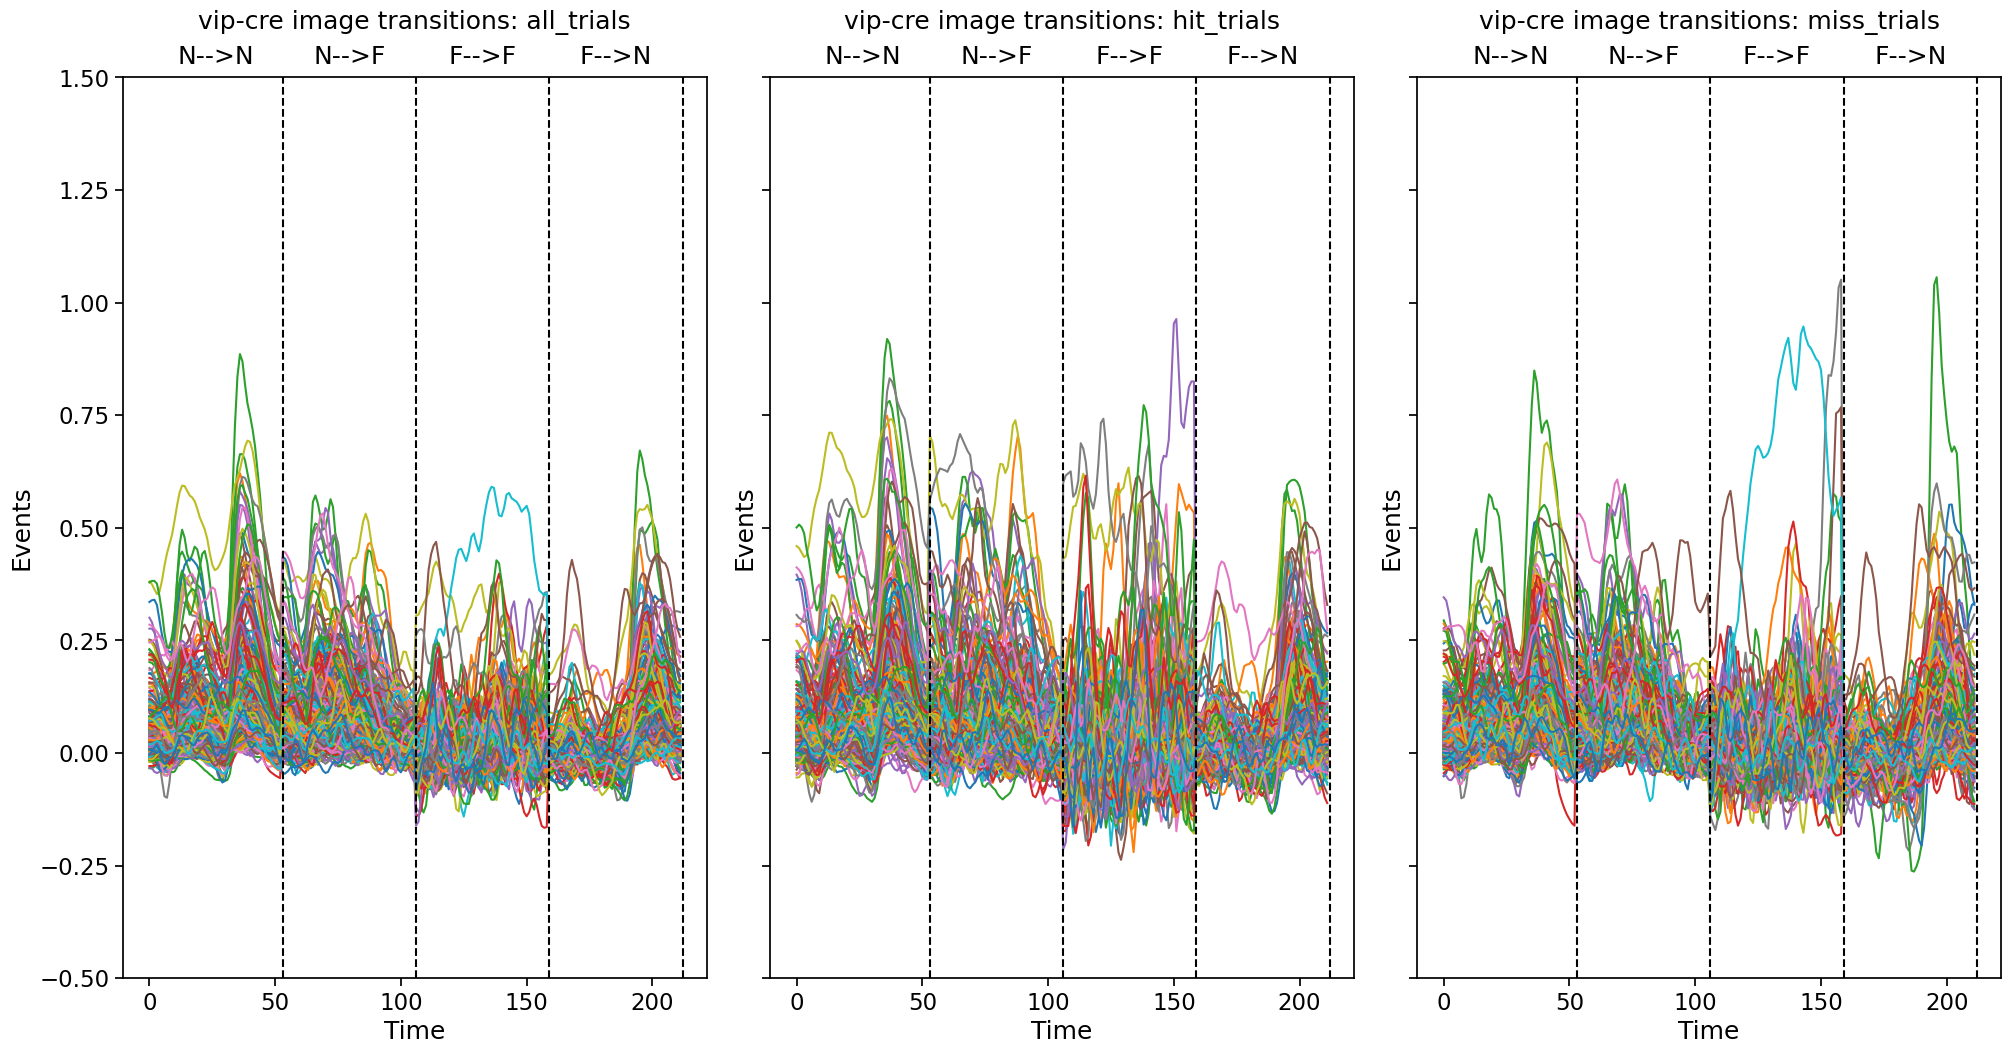

In [49]:
# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
fig.tight_layout()

# Loop over dff_groups_list and plot each on a different subplot
for n, dff_array in enumerate(dff_groups_list):
    dff_array = np.array(dff_groups_list[n])
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()), -1)

    axs[n].plot(dff_flat.T)

    for i in range(4):
        timepts = dff_array.shape[-1]
        axs[n].axvline(timepts * (i + 1), color='k', linestyle='--')

        # Get the y-limit of the current subplot
        plt.ylim([-0.5, 1.5])
        ylim = axs[n].get_ylim()
        upper_ylim = ylim[1]

        # Add the text labels
        axs[n].text(timepts * (i + 1) - timepts / 2, upper_ylim + 0.03, name_list[i], 
                    horizontalalignment='center')

    # Set the title, ylabel, and xlabel for each subplot
    axs[n].set_title(f'{end_folder} image transitions: ' + groups_types_list[n], pad=35)
    axs[n].set_ylabel('∆F/F')
    axs[n].set_xlabel('Time')

# Save the entire figure as an SVG (optional)
# plt.savefig(image_path + 'dff_lineplot_all_trials.svg', format='svg')

# Display the plot
plt.show()

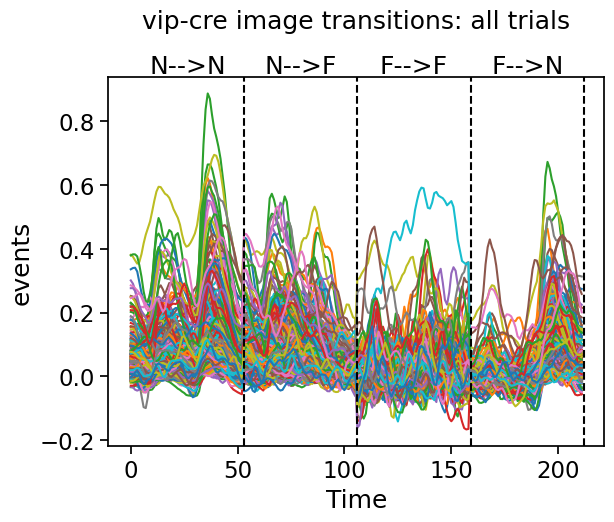

In [38]:
dff_array = np.array(dff_groups_list[0])
    
filtevent_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)   

plt.plot(filtevent_flat.T);
for i in range(4):
    timepts = filtevent_array.shape[-1]
    plt.axvline(timepts*(i+1), color='k', linestyle='--')
    #plt.ylim([0, 0.5])
    ylim = plt.gca().get_ylim()

    # Extract the upper limit
    upper_ylim = ylim[1]
    plt.text(timepts*(i+1)-timepts/2, upper_ylim+0.01, name_list[i], horizontalalignment='center')
    
plt.title(f'{end_folder} image transitions: all trials', pad=35)
plt.ylabel('events');
plt.xlabel('Time');

# Save as SVG
#plt.savefig(image_path+'dff_lineplot_'+curr_name_svg, format="svg")

In [29]:
filtevent_array.shape

(361, 4, 18)

In [ ]:
filtevent_array = np.array(filtevent_groups_list[1])
    
filtevent_flat = filtevent_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)   

plt.plot(filtevent_flat.T);
for i in range(4):
    timepts = filtevent_array.shape[-1]
    plt.axvline(timepts*(i+1), color='k', linestyle='--')
    plt.ylim([0, 0.5])
    ylim = plt.gca().get_ylim()

    # Extract the upper limit
    upper_ylim = ylim[1]
    plt.text(timepts*(i+1)-timepts/2, upper_ylim+0.01, name_list[i], horizontalalignment='center')
    
plt.title(f'{end_folder} image transitions: hit trials', pad=35)
plt.ylabel('events');
plt.xlabel('Time');

# Save as SVG
#plt.savefig(image_path+'dff_lineplot_'+curr_name_svg, format="svg")

In [ ]:
filtevent_array = np.array(filtevent_groups_list[2])
    
filtevent_flat = filtevent_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)   

plt.plot(filtevent_flat.T);
for i in range(4):
    timepts = filtevent_array.shape[-1]
    plt.axvline(timepts*(i+1), color='k', linestyle='--')
    plt.axvline(timpts
    plt.ylim([0, 0.5])
    ylim = plt.gca().get_ylim()

    # Extract the upper limit
    upper_ylim = ylim[1]
    plt.text(timepts*(i+1)-timepts/2, upper_ylim+0.01, name_list[i], horizontalalignment='center')
    
plt.title(f'{end_folder} image transitions: miss trials', pad=35)
plt.ylabel('events');
plt.xlabel('Time');

# Save as SVG
#plt.savefig(image_path+'dff_lineplot_'+curr_name_svg, format="svg")

In [ ]:
data_array = np.array(data_list)


In [ ]:
data_flat = data_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)
data_array.shape

In [ ]:
curr_name_svg = end_folder + '_combined_concat_imagechange_' '.svg'
curr_name_svg

In [ ]:
sns.heatmap(data_flat,cmap='magma')
name_list = ['N->N', 'N->F', 'F->F', 'F->N']

line_offset = 0
for i in range(4):
    timepts = data_array.shape[-1]
    plt.axvline(timepts*(i+1), color='w')
    plt.text(timepts*(i+1)-timepts/2, -5, name_list[i], horizontalalignment='center')
    
    temp_df = vip_stacked_dict[mouse_id_list[i]]
    cell_ct = len(temp_df.cell_specimen_id.unique())
    plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    line_offset = line_offset + cell_ct

# line_offset = 0
# for mouse_id in mouse_id_list:
#     temp_df = vip_stacked_dict[mouse_id]
#     cell_ct = len(temp_df.cell_specimen_id.unique())
#     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
#     line_offset = line_offset + cell_ct
    
    
plt.title(f'{end_folder} combined cell averaged image transitions', pad=25)
plt.ylabel('Cell #');
plt.xlabel('Time');
    
# Save as SVG
plt.savefig(image_path+'dff_heatmap_'+curr_name_svg, format="svg")

In [ ]:
plt.plot(data_flat.T);
for i in range(4):
    timepts = data_array.shape[-1]
    plt.axvline(timepts*(i+1), color='k', linestyle='--')
    
    ylim = plt.gca().get_ylim()

    # Extract the upper limit
    upper_ylim = ylim[1]
    plt.text(timepts*(i+1)-timepts/2, upper_ylim+0.03, name_list[i], horizontalalignment='center')
    
plt.title(f'{end_folder} {mouse_id} cell averaged image transitions', pad=35)
plt.ylabel('∆F/F');
plt.xlabel('Time');

# Save as SVG
plt.savefig(image_path+'dff_lineplot_'+curr_name_svg, format="svg")

In [ ]:
data_flat

In [ ]:
data_flat.shape

In [ ]:
# plt.plot(np.array([data_list[i][0] for i in range(78)]).T);

In [ ]:
z_data_flat = stats.zscore(data_flat,axis=1)

In [ ]:
z_data_flat.shape

In [ ]:
plt.plot(z_data_flat.T);
for i in range(4):
    timepts = data_array.shape[-1]
    plt.axvline(timepts*(i+1), color='k', linestyle='--')
    
    ylim = plt.gca().get_ylim()

    # Extract the upper limit
    upper_ylim = ylim[1]
    plt.text(timepts*(i+1)-timepts/2, upper_ylim+0.2, name_list[i], horizontalalignment='center')
    
plt.title(f'{end_folder} {mouse_id} cell averaged image transitions', pad=35)
plt.ylabel('∆F/F');
plt.xlabel('Time');

# Save as SVG
plt.savefig(image_path+'dff_lineplot_'+curr_name_svg, format="svg")

In [ ]:
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, 
                             verbose=0, random_state=None, copy_x=True, algorithm='lloyd')


